# Importing the required modules
First, we need to import the necessary modules. We will use TensorFlow as our main library to create and train the model. From Keras, we import layers and regularizers to build our model.

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Setting up constants
Here, we set the path to the directories containing the training and test datasets. We also set the image size and batch size.

In [4]:
path_to_train_covers = r'/kaggle/input/books-dataset/title30cat/224x224/Train'
path_to_test_covers = r'/kaggle/input/books-dataset/title30cat/224x224/Test'

image_size = (224, 224)
batch_size = 16


# Loading and preprocessing the data
First we load the image data from the directory and split into training, validation and test sets, apply the preprocessing required for the ConvNeXt base model, and perform data augmentation to improve the model's ability to generalize.

In [5]:
train_val_data = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_train_covers,
    validation_split=0.2,
    subset='training',
    image_size=image_size,
    batch_size=batch_size,
    seed=42,
    shuffle=True
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_test_covers,
    image_size=image_size,
    batch_size=batch_size,
    seed=42,
    shuffle=True
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    path_to_train_covers,
    validation_split=0.2,
    subset='validation',
    image_size=image_size,
    batch_size=batch_size,
    seed=42,
    shuffle=True
)

# Apply one-hot encoding to the labels
num_classes = len(train_val_data.class_names)
train_val_data = train_val_data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
val_data = val_data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))
test_data = test_data.map(lambda x, y: (x, tf.one_hot(y, num_classes)))

# Configure prefetching for improved data loading performance
train_val_data = train_val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)


# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomRotation(0.05),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

Found 51300 files belonging to 30 classes.
Using 41040 files for training.
Found 5700 files belonging to 30 classes.
Found 51300 files belonging to 30 classes.
Using 10260 files for validation.


# Image plot to ensure images are loaded correctly.

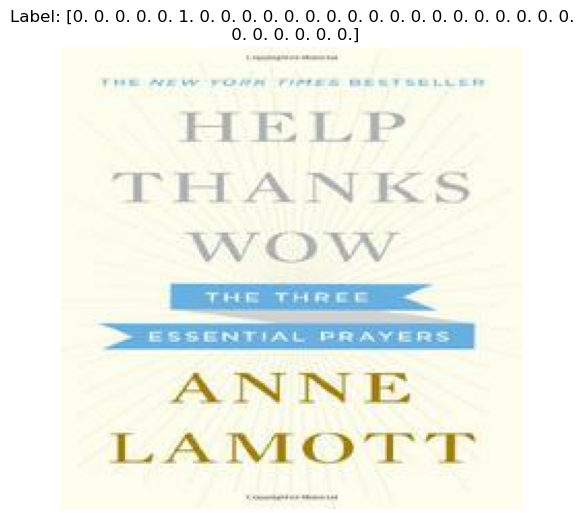

In [6]:
import matplotlib.pyplot as plt

for images, labels in train_val_data.take(1):
    image = images[0].numpy().astype("uint8")
    label = labels[0]

# Plot the image and print the label
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title(f'Label: {label.numpy()}')
plt.axis('off')
plt.show()


# Building the model
We build our model by creating a ConvNeXt base model pre-trained on ImageNet and add a few more layers on top to adapt it to our book genre classification. We add early stopping to avoid overfitting and lower the learning rate for the fine-tuning.

In [12]:
base_model = tf.keras.applications.ConvNeXtBase(
    model_name="convnext_base",
    include_top=False,
    weights="imagenet",
    input_shape=image_size + (3,),
    pooling='avg'
)

base_model.trainable = False

inputs = layers.Input(shape=image_size + (3,))
x = base_model(inputs, training=False)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_val_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stopping] 
)

block_names = ['convnext_base_stage_3_block', 'convnext_base_stage_2_block', 'convnext_base_stage_1_block']

for layer in base_model.layers:
    if any(block in layer.name for block in block_names):
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

# Continue training the model
history_fine = model.fit(
    train_val_data,
    epochs=10,
    validation_data=val_data,
    callbacks=[early_stopping]
)

Epoch 1/10
2565/2565 [==============================] - 649s 246ms/step - loss: 3.2048 - categorical_accuracy: 0.2091 - val_loss: 2.5975 - val_categorical_accuracy: 0.2922
Epoch 2/10
2565/2565 [==============================] - 621s 242ms/step - loss: 2.8899 - categorical_accuracy: 0.2529 - val_loss: 2.5848 - val_categorical_accuracy: 0.2980
Epoch 3/10
2565/2565 [==============================] - 620s 242ms/step - loss: 2.8726 - categorical_accuracy: 0.2541 - val_loss: 2.5649 - val_categorical_accuracy: 0.3021
Epoch 4/10
2565/2565 [==============================] - 641s 250ms/step - loss: 2.8741 - categorical_accuracy: 0.2544 - val_loss: 2.5788 - val_categorical_accuracy: 0.2956
Epoch 5/10
2565/2565 [==============================] - 621s 242ms/step - loss: 2.8608 - categorical_accuracy: 0.2564 - val_loss: 2.5856 - val_categorical_accuracy: 0.2967
Epoch 6/10
2565/2565 [==============================] - 620s 242ms/step - loss: 2.8683 - categorical_accuracy: 0.2568 - val_loss: 2.5417 - v

# Evaluating the model and graphing performance

357/357 [==============================] - 69s 192ms/step - loss: 2.5330 - categorical_accuracy: 0.2991
Test accuracy: 0.29912281036376953
Test loss: 2.532959461212158


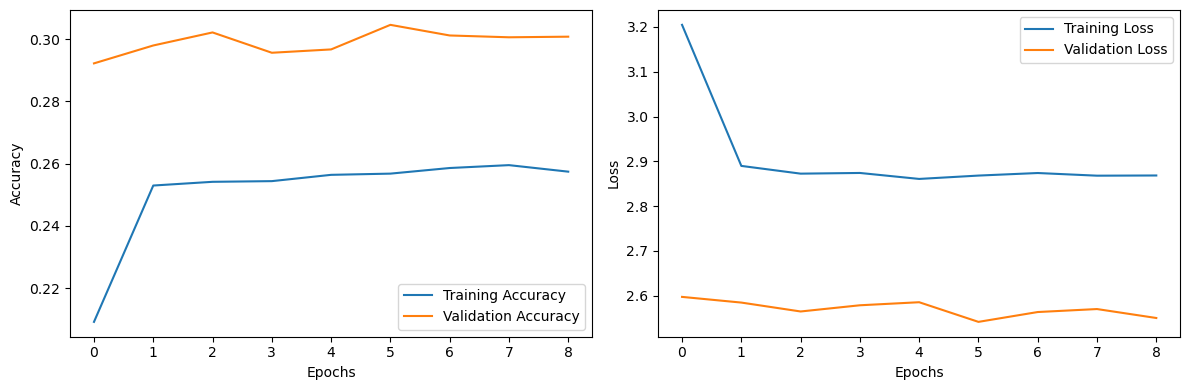

In [13]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


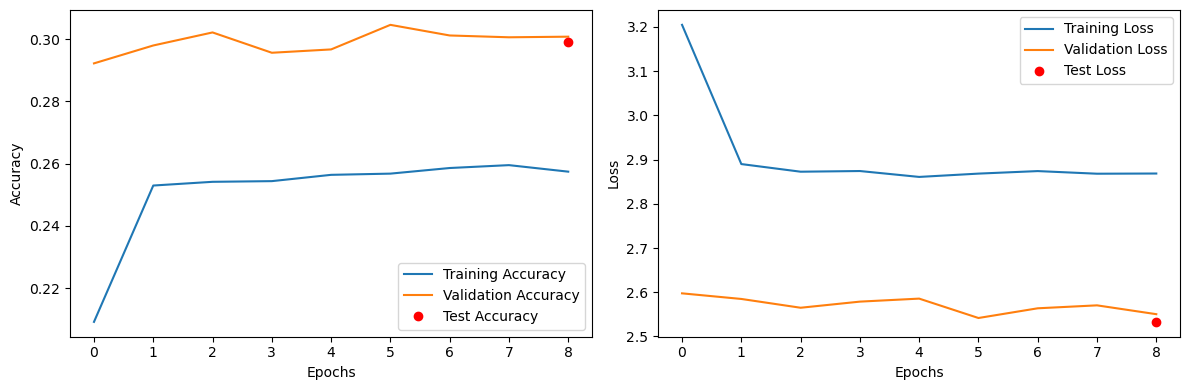

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.plot(len(history.history['categorical_accuracy']) - 1, test_acc, 'ro', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(len(history.history['loss']) - 1, test_loss, 'ro', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Find the last 3 layers so we can unfreeze them for fine-tuning the model.

In [10]:
block_names = []
for layer in reversed(base_model.layers):
    layer_parts = layer.name.split('_')
    if 'convnext_base_stage' in layer.name and 'block' in layer.name:
        block_name = '_'.join(layer_parts[:5])
        if block_name not in block_names:
            block_names.append(block_name)
        if len(block_names) == 3:
            break
print(block_names)


['convnext_base_stage_3_block', 'convnext_base_stage_2_block', 'convnext_base_stage_1_block']
